# Analyzing Plaskett images with a Starlink streak

Unlike previous DECam observations, these images don't have an easy way to run the Rubin Science Pipelines for data reduction, so we will instead rely on the Plaskett team's own reduced images.

**This notebook assumes the pixel values in the processed FITS image are in units of nJy.** You cannot trust the results of the analysis if this is an incorrect assumption.

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import pandas as pd

from astropy.io import fits
from astropy import coordinates as coord
from astropy.time import Time
import astropy.units as u
import astropy.constants as c
from astropy.wcs import WCS
from astropy.modeling import models, fitting
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize

In [2]:
path_to_reduced_fits = '/project/mrawls/starlink/plaskett-observations/Proc/acodao_c182_2021_016007.fits'

In [3]:
hdu = fits.open(path_to_reduced_fits)
imageArray = hdu[0].data
header = hdu[0].header

### Display the image to see what we're working with

<IPython.core.display.Javascript object>


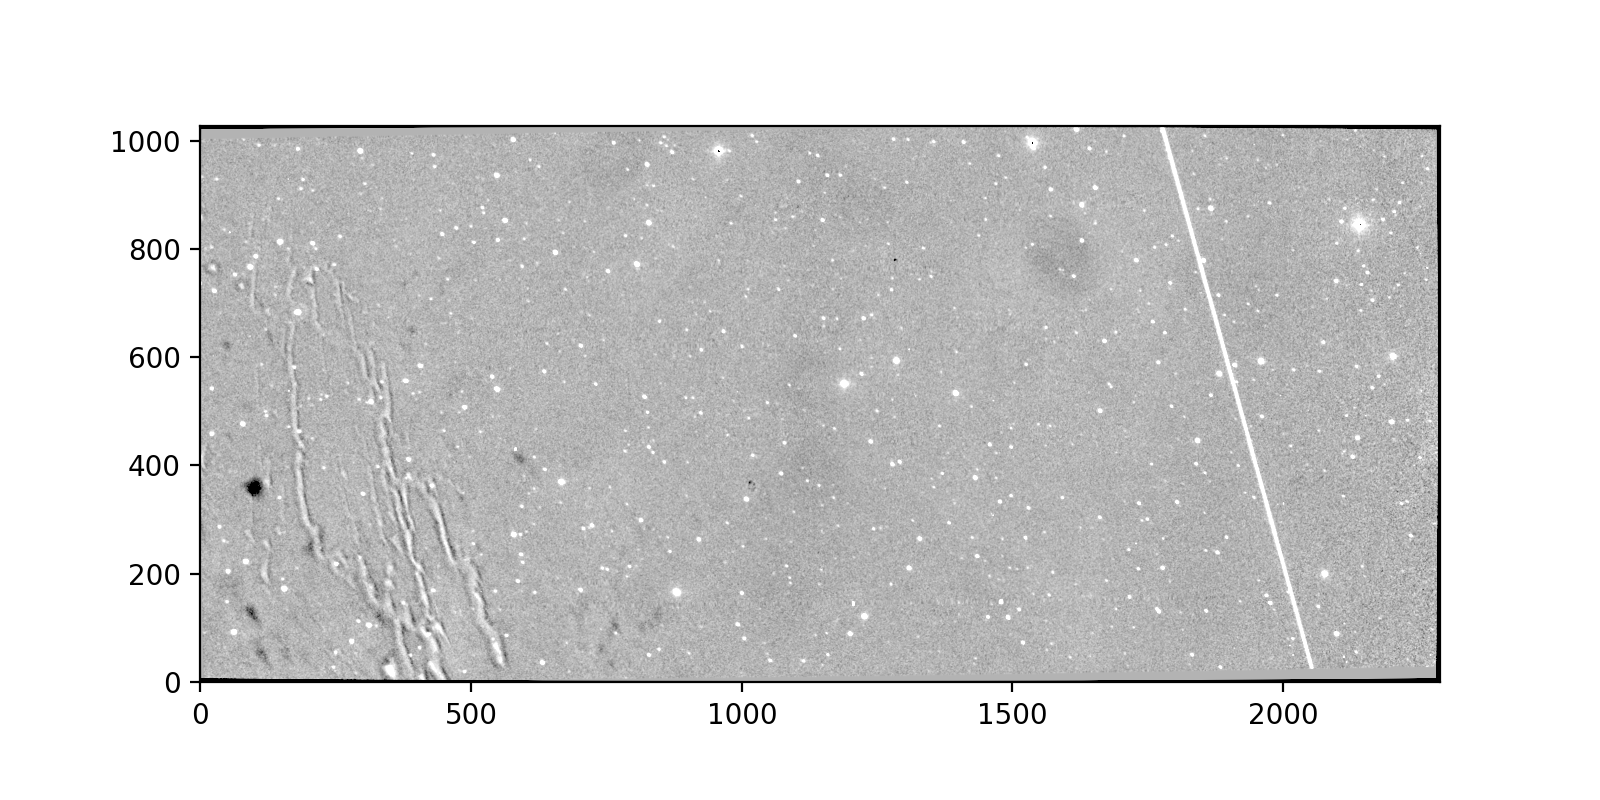

In [4]:
norm = ImageNormalize(imageArray, interval=ZScaleInterval(), stretch=SqrtStretch())
fig = plt.figure(figsize=(8, 4))
#fig.add_subplot(121)
plt.imshow(imageArray, cmap='gray', norm=norm, origin='lower')

Manually panning and zooming around the image, I located two endpoints of the satellite streak

In [5]:
trailPoint1 = [1782, 1003]
trailPoint2 = [2050, 32]

### Use astropy and header keywords to get crucial metadata

In [6]:
location = coord.EarthLocation.of_site('dao')
ra = header['RA']
dec = header['DEC']
dateObs = header['DATE-OBS']

In [7]:
dateObsAstropy = Time(dateObs)
dateObsAstropy

<Time object: scale='utc' format='isot' value=2021-07-28T04:54:08.000>

In [10]:
sky_coord = coord.SkyCoord(ra+dec, unit=(u.hour, u.deg))
sky_coord
wcs = WCS(header)
wx, wy = wcs.wcs_pix2world(trailPoint1[0], trailPoint1[1], 0)
print(wx, wy)

296.45547607558507 39.20613974132005


### Get things in Azimuth and Altitude coordinates

In [13]:
def trailPointToAzAlt(header, trailPoint, dateOverride=None, site='ctio'):
    """Get the Azimuth and Altitude corresponding to an x, y image position.

    Parameters
    ----------
    header : `astropy.io.fits.header.Header`
        FITS header of image being analyzed
    trailPoint : `list` with 2 values
        [x, y] coordinates of a point in image, in pixels
    dateOverride : `str` or `None`
        NOT YET IMPLEMENTED.
        If the visitInfo date is wrong, this permits a user to pass along
        the correct date to use. Must be e.g. '2020-01-01' format.
    loc : `str`
        One of astropy.coordinates.EarthLocation.get_site_names()

    Returns
    -------
    altAz : `astropy.coordinates.SkyCoord`
        Sky Coordinate transformed to an Alt/Az frame
    """
    wcs = WCS(header)
    #trailPointCoord = wcs.pixel_to_world(trailPoint)  # THIS EXPECTS A 2D THING
    trailPointCoord = wcs.wcs_pix2world(trailPoint[0], trailPoint[1], 0)  # THIS MAY BE DICEY
    #print(trailPointCoord)
    dateObs = header['DATE-OBS']  # THIS ISN'T VERY GENERIC
    dateObsAstropy = Time(dateObs)
    sky_coord = coord.SkyCoord(trailPointCoord[0], trailPointCoord[1], unit=u.deg)
    #print(sky_coord)
    location = coord.EarthLocation.of_site(site)
    altAz_frame = coord.AltAz(obstime=dateObsAstropy, location=location)
    altAz = sky_coord.transform_to(altAz_frame)

    return altAz

In [14]:
test = trailPointToAzAlt(header, trailPoint2, site='dao')
print(test.alt)
print(test.az)
print(test.secz)

59d45m35.4022s
92d52m06.7936s
1.1575119619689687


### Compute speed of the satellite

In [15]:
def computeDistanceToSatellite(airmass, height):
    """Given airmass and range, compute how far away a satellite actually is.

    Parameters
    ----------
    airmass : `float`
        Airmass of the observation.
    height : `astropy.Quantity`
        Altitude or height of satellite above the surface of Earth

    Returns
    -------
    x : `float`
        The (small) angle between line of sight and (Radius of the Earth + height)
    d: `astropy.Quantity`
        The distance between the satellite and an observer on earth
    """
    zangle = np.arccos(1./airmass)
    x = np.arcsin(c.R_earth * np.sin(zangle)/(c.R_earth + height))
    if np.isclose(x, 0):
        d = height
    else:
        d = np.sin(zangle - x) * c.R_earth/np.sin(x)
    return x, d


def computeAngularSpeed(header, trailPoint1, trailPoint2, dateOverride=None,
                        site="ctio", height=550*u.km):
    """
    Compute the angular speed of a satellite.

    Parameters
    ------
    header : `astropy.io.fits.header.Header`
        FITS header of image being analyzed
    trailPoint1 : `list` with 2 values
        [x1, y1] coordinates of first point on trail, in pixels
    trailPoint2 : `list` with 2 values
        [x2, y2] coordinates of second point on trail, in pixels
    dateOverride : `str` or `None`
        If the header date is wrong, this permits a user to pass along
        the correct date to use. Must be e.g. '2020-01-01' format.
    site : `str`
        One of astropy.coordinates.EarthLocation.get_site_names()
        Such as "ctio"
    height : `astropy.Quantity`, optional
        Altitude or height of satellite above the surface of Earth
        Default is 550 km

    Returns
    -------
    speed : `astropy.Quantity`
        Angular speed as seen from the surface of Earth (angle per time)
    """
    dateObs = header['DATE-OBS']
    dateObsAstropy = Time(dateObs)
    if dateOverride:
        print('Date override not yet implemented')
    
    try:
        pixelScale = header['SECPIX']
    except KeyError:
        pixelScale = (header['SECPIX1'] + header['SECPIX2'])/2.
    exposureTime = header['EXPTIME']
    location = coord.EarthLocation.of_site(site)
    altAz1 = trailPointToAzAlt(header, trailPoint1, dateOverride, site)
    altAz2 = trailPointToAzAlt(header, trailPoint2, dateOverride, site)
    alt1 = altAz1.alt
    az1 = altAz1.az
    alt2 = altAz2.alt
    az2 = altAz2.az
    airmass = altAz1.secz  # about the same for both points, presumably
    omega = np.sqrt(c.G * c.M_earth/(c.R_earth + height)**3)  # angular speed from center of earth
    orbitSpeed = omega * (c.R_earth + height)
    x, d = computeDistanceToSatellite(airmass, height)
    # x is the angle between line of sight and (Radius of the Earth + height)
    # d is the distance between the satellite and an observer on earth
    # Account for the fact that the trail does not pass through zenith
    
    if (alt1 == 0 and alt2 == 0 and az1 == 0 and az2 == 0):
        tanSpeed = orbitSpeed * np.cos(x)  # project orbitSpeed to perpendicular to line of sight
        # angleHorizon = 90
    else:
        tanTheta = (az2 - az1)/(alt2 - alt1)
        xSquare = 1./(1 + np.tan(x)**2 + tanTheta**2)
        zSquare = xSquare*np.tan(x)**2
        tanSpeed = orbitSpeed * np.sqrt(1 - zSquare)
        # angleHorizon = 90 - abs(np.degrees(np.arctan(tanTheta)))
    angularSpeed = tanSpeed/d * u.rad  # angular speed from surface of Earth

    return angularSpeed

In [17]:
speed = computeAngularSpeed(header, trailPoint1, trailPoint2, site='dao')
speed.to(u.deg/u.s)

<Quantity 0.68983261 deg / s>

## Do all the rest of the work in a couple of functions
Read the docstrings! They are your friend!

In [20]:
def fit_columns(sliced, center=20, doPlot=False):
    """Return the fitted gaussian widths (stddevs)
    of all columns in a numpy array.
    
    Called by starlinkAnalyze on the `sliced` array to
    measure the satellite trail width at each point along it.
    
    Paramters
    ---------
    sliced : `np.array` of mini-rotated-image containing
        the satellite trail (a 2D array)
    center : `int` of approximate satellite trail width
    doPlot : `boolean`

    Returns
    -------
    means : `np.array` of Gaussian fit means
    widths : `np.array` of Gaussian fit stddevs
    
    """
    t_init = models.Gaussian1D(amplitude=2000, mean=center)
    fit_t = fitting.LevMarLSQFitter()
    widths = np.zeros(len(sliced), dtype=np.float32)
    means = np.zeros(len(sliced), dtype=np.float32)
    if doPlot:
        plt.figure()
    for i in range(len(sliced)):
        y = sliced[...,i]
        x = np.arange(0, len(y), dtype=np.float32)
        t = fit_t(t_init, x, y)
        widths[i] = t.stddev.value
        means[i] = t.mean.value
        if doPlot:
            plt.plot(x, y)
            plt.plot(x, t(x))
    return means, widths


def starlinkAnalyze(imageArray, header, site, trailPoint1, trailPoint2, 
                    trailWidth=20, nudge=0, doPlotProfiles=False):
    """Analyze an image processed with the LSST Science Pipelines
    containing a satellite trail.
    
    Parameters
    ----------
    imageArray : `np.ndarray`
        Array of reduced image data, presumably in units of counts
    header : `astropy.io.fits.header.Header`
        Header corresponding to imageArray
    site : `str`
        Corresponding to Astropy observatory sites, e.g., 'dao' or 'ctio'
    trailPoint1 : `list` with 2 values
        [x1, y1] coordinates of first point on trail, in pixels
    trailPoint2 : `list` with 2 values
        [x2, y2] coordinates of second point on trail, in pixels
    trailWidth : `int`
        Approximate half-width of satellite trail, in pixels, optional
        Default is 20
    nudge : `int`
        Amount by which to adjust the y-value of the middle of the
        satellite trail, optional
        Default is 0

    Returns
    -------
    results : `dict`
        Results dict containing over a dozen relevant values
        Note that all numeric quantities are rounded to 2 decimal places

    Notes
    -----
    For best results, display or plot the image beforehand,
    and manually choose trailPoint1 and trailPoint2 so they are
    at opposite ends of the satellite trail.
        
    """
    # Get sun location and phase angle
    ra = header['RA']  # assumes it's a string in hours
    dec = header['DEC']  # assumes it's a string in degrees
    dateObs = header['DATE-OBS']
    dateObsAstropy = Time(dateObs)
    sky_coord = coord.SkyCoord(ra+dec, unit=(u.hour, u.deg))
    location = coord.EarthLocation.of_site(site)
    aa_frame = coord.AltAz(obstime=dateObsAstropy, location=location)
    aa_coord = sky_coord.transform_to(aa_frame)
    sun_coord = coord.get_sun(dateObsAstropy)
    sun_aa = sun_coord.transform_to(aa_frame)
    phase_angle = sky_coord.separation(sun_coord)
    
    # Get pixel scale in arcsec, exposure time, and compute alt/az
    try:
        pixelScale = header['SECPIX']
    except KeyError:
        pixelScale = (header['SECPIX1'] + header['SECPIX2'])/2.
    exposureTime = header['EXPTIME']
    #altAz = trailPointToAzAlt(header, trailPoint1, site='dao')
    #altAz = sky_coord.transform_to(coord.AltAz(obstime=dateObsAstropy, location=location))
    
    # Get background info since it was subtracted from image
    # NOT RELEVANT FOR NON-LSST-PROCESSED IMAGES
    #background = butler.get('calexpBackground', dataId=dataId)
    #background_in_nJy = photoCalib.instFluxToNanojansky(background.getImage().getArray().mean())
    #background_per_area = (background_in_nJy) / pixelScale.asArcseconds()**2
    #background_mag_per_arcsec_squared = (background_per_area*u.nJy).to(u.ABmag).value
    
    # Rotate image data so the trail is horizontal
    angle = np.arctan2(trailPoint2[1] - trailPoint1[1], 
                       trailPoint2[0] - trailPoint1[0]) * u.rad
    slope = (trailPoint2[1] - trailPoint1[1])/(trailPoint2[0] - trailPoint1[0])
    yint = trailPoint1[1] - slope*trailPoint1[0]
    #imageArray = njyImage.image.array
    xmax = len(imageArray[0])
    ymax = len(imageArray)
    rotatedArray = rotate(imageArray, angle)
    trailRotYPart1 = np.abs(xmax * np.sin(angle))
    trailRotYPart2 = (xmax*slope + yint) * np.cos(angle)
    trailRotY = int(trailRotYPart1 + trailRotYPart2)
    trailRotY = trailRotY + nudge
    x_length = trailPoint2[0] - trailPoint1[0]
    x_start = int(trailPoint1[0])
    x_end = int(trailPoint2[0])
    trailRotXPart1 = np.abs(ymax - yint) * np.sin(angle)  # used to be np.abs on whole thing
    trailRotXPart2 = trailPoint1[0]/np.cos(angle)  # used to be np.abs on whole thing
    trailRotX = int(trailRotXPart1 + trailRotXPart2)
    trailLength = int(np.sqrt((trailPoint2[1] - trailPoint1[1])**2 + 
                              (trailPoint2[0] - trailPoint1[0])**2))
    
    # Define a new array containing a slice of the image with the trail in it
    sliced = rotatedArray[trailRotY - trailWidth:trailRotY + trailWidth,
                          trailRotX:trailRotX + trailLength]
    
    # Make sure nothing horrible is happening with outliers in the trail
    FcorrFactor = np.median(sliced.sum(axis=0))/np.mean(sliced.sum(axis=0))
    #print(FcorrFactor)  # should be very close to 1
    
    # Make plots of satellite trail
    norm = ImageNormalize(imageArray, interval=ZScaleInterval(), stretch=SqrtStretch())
    fig1 = plt.figure(figsize=(8, 4))
    fig1.add_subplot(121)
    plt.imshow(imageArray, cmap='gray', norm=norm, origin='lower')
    # Draw dotted blue line along satellite trail
    plt.plot([trailPoint1[0], trailPoint2[0]], [trailPoint1[1], trailPoint2[1]],
             ls=':', color='C0', lw=2)
    plt.title('Original image with satellite trail')
    fig1.add_subplot(122)
    plt.imshow(rotatedArray, cmap='gray', norm=norm, origin='lower')
    plt.axhline(y=trailRotY - trailWidth, ls=':', color='C1', lw=2)
    plt.axhline(y=trailRotY + trailWidth, ls=':', color='C1', lw=2)
    plt.axhline(y=trailRotY, ls=':', color='C0', lw=2)
    # Draw purple dots at start and end of satellite trail
    plt.plot(trailRotX, trailRotY, marker='o', color='C4')
    plt.plot(trailRotX + trailLength, trailRotY, marker='o', color='C4')
    plt.title('Rotated image with horizontal satellite trail')
    
    fig2 = plt.figure(figsize=(8, 4))
    ax2 = fig2.subplots()
    ax2.plot(sliced.sum(axis=1), marker='o')
    plt.xlabel('Pixel index')
    plt.ylabel('Flux')
    plt.title('Summed flux profile')
    
    fig3 = plt.figure(figsize=(8, 4))
    ax3 = fig3.subplots()
    ax3.plot(sliced.sum(axis=0))
    plt.xlabel('Rotated X pixel position')
    plt.ylabel('Flux')
    plt.title('Flux along the trail')
    
    # Calculate trail brightness
    summed_flux = sliced.sum()
    means, widths = fit_columns(sliced, center=trailWidth)
    avg_fwhm = 2.355 * np.mean(widths)
    flux_per_pixel = summed_flux / (avg_fwhm*trailLength)  # flux units per square pixel
    flux_per_arcsec_squared = flux_per_pixel / pixelScale**2  # flux units per arcsec
    mag_per_arcsec_squared = (flux_per_arcsec_squared*u.nJy).to(u.ABmag).value  # ASSUMES FLUX UNITS ARE nJy !!!
    
    # Some correction factors
    corr = 2.5 * np.log10(exposureTime)  # correction for exposure time, assumed to be in seconds
    dist_1_sec = computeAngularSpeed(header, trailPoint1, trailPoint2, site=site) * u.s
    #dist_1_sec = 1800 * u.arcsec  # distance traveled in sky by satellite in 1 sec THIS ASSUMES A VELOCITY
    
    corr2 = 2.5 * np.log10(dist_1_sec.value * avg_fwhm * pixelScale)  # correction for sky covered in 1 second
    stationary_mag = mag_per_arcsec_squared - corr - corr2

    # Effective satellite size
    #size_eff = np.sqrt(avg_fwhm**2 - (psfRadius*2.355)**2) * pixelScale \
    #           * visitInfo.getBoresightAirmass() * u.arcsec

    # Save relevant information to results dict
    results = dict()
    #results['Visit'] = dataId['visit']
    #results['CCD'] = dataId['ccd']
    results['Date and time (UTC)'] = dateObsAstropy
    results['Exposure time'] = exposureTime * u.s
    results['Boresight Az'] = aa_coord.az.to(u.deg).value * u.deg
    results['Boresight Alt'] = aa_coord.alt.to(u.deg).value * u.deg
    results['Sun Az'] = sun_aa.az.to(u.deg).value * u.deg
    results['Sun Alt'] = sun_aa.alt.to(u.deg).value * u.deg
    results['Phase angle'] = phase_angle.to(u.deg).value * u.deg
    results['Airmass'] = aa_coord.secz
    #results['Image PSF radius'] = psfRadius * pixelScale * u.arcsec
    #results['Image PSF FWHM'] = psfRadius*2.355 * pixelScale * u.arcsec
    #results['Background (mag)'] = background_mag_per_arcsec_squared * u.arcsec**(-2)
    results['Summed trail flux'] = summed_flux * u.nJy
    results['Trail FWHM'] = avg_fwhm * pixelScale * u.arcsec
    results['Trail length'] = trailLength * pixelScale * u.arcsec
    results['Raw trail flux'] = flux_per_arcsec_squared * u.nJy * u.arcsec**(-2)
    results['Raw trail (mag)'] = mag_per_arcsec_squared * u.arcsec**(-2)
    results['Corrected trail (mag)'] = (mag_per_arcsec_squared - corr) * u.arcsec**(-2)
    results['Stationary magnitude'] =  stationary_mag
    results['Corrected stationary mag'] = (stationary_mag - 5*np.log10(aa_coord.secz))
    #results['Effective satellite size'] = size_eff
    
    # Round overly precise values
    for key, value in results.items():
        if isinstance(value, u.Quantity):
            results[key] = value.round(2)
        elif isinstance(value, float):
            results[key] = np.round(value, 2)
    
    return results

<IPython.core.display.Javascript object>


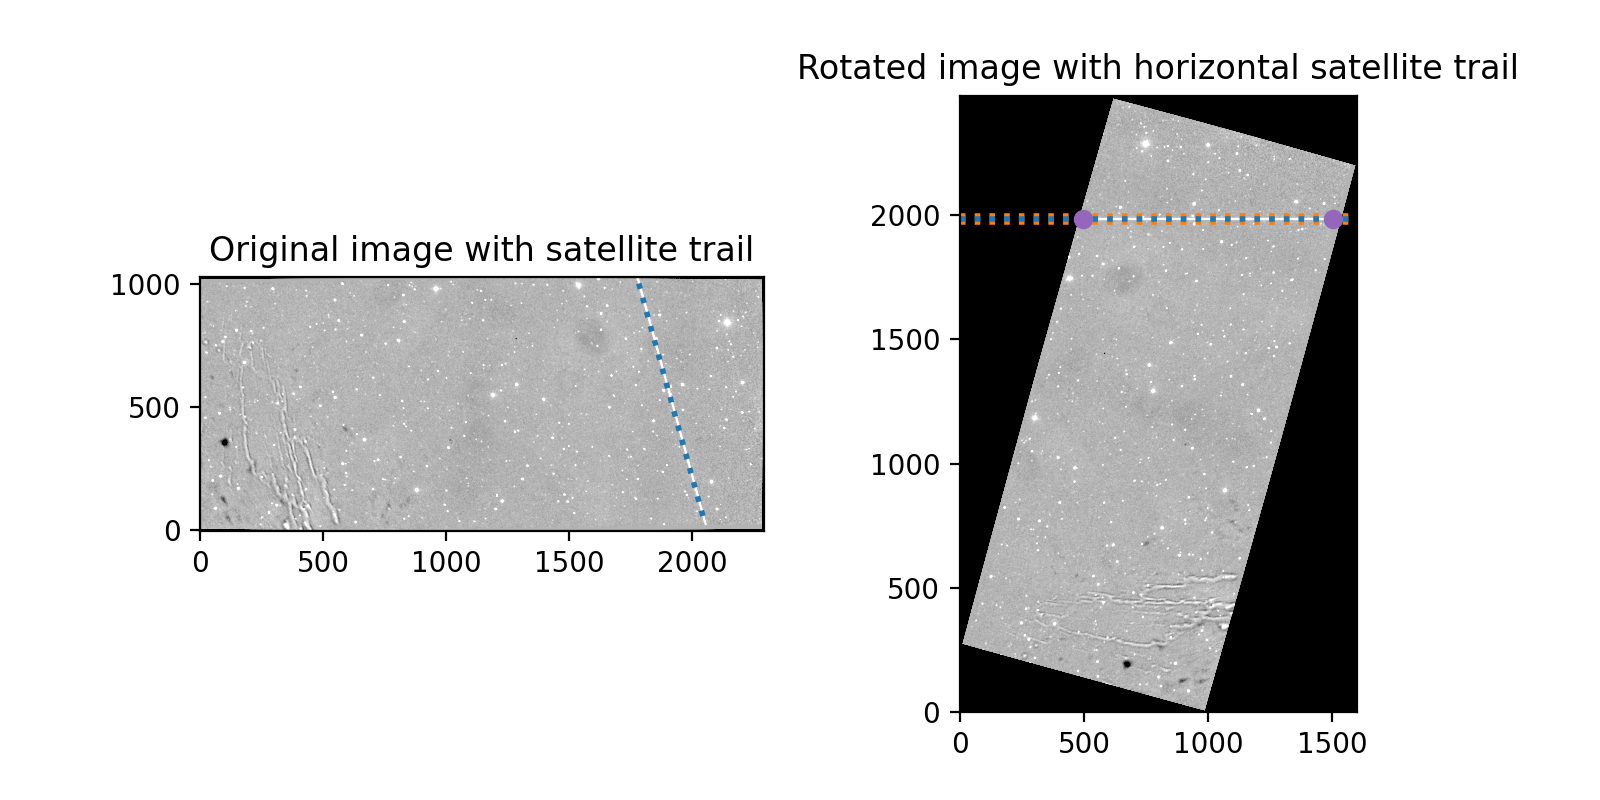

<IPython.core.display.Javascript object>


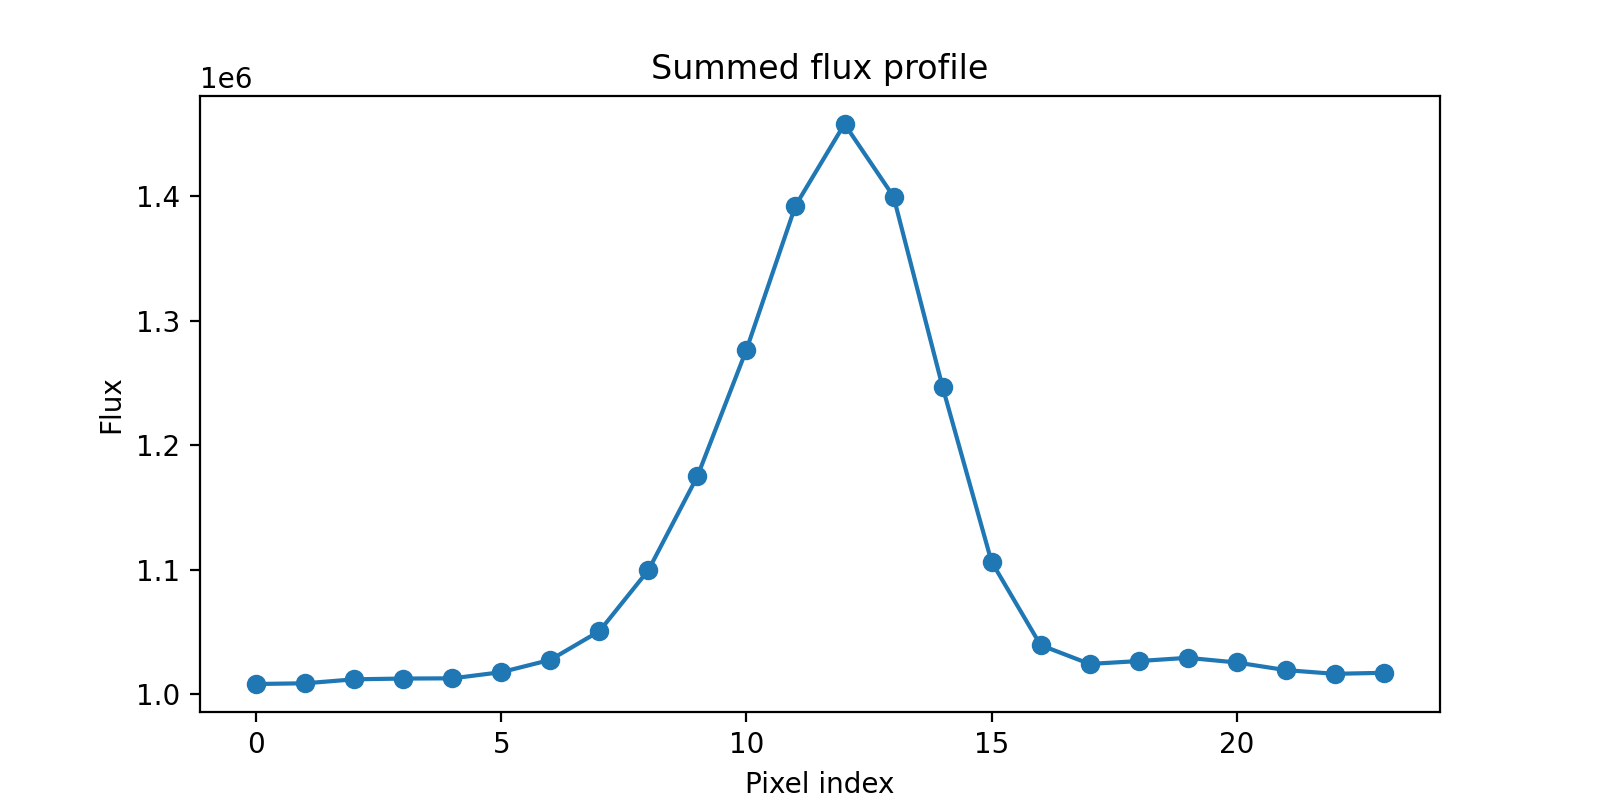

<IPython.core.display.Javascript object>


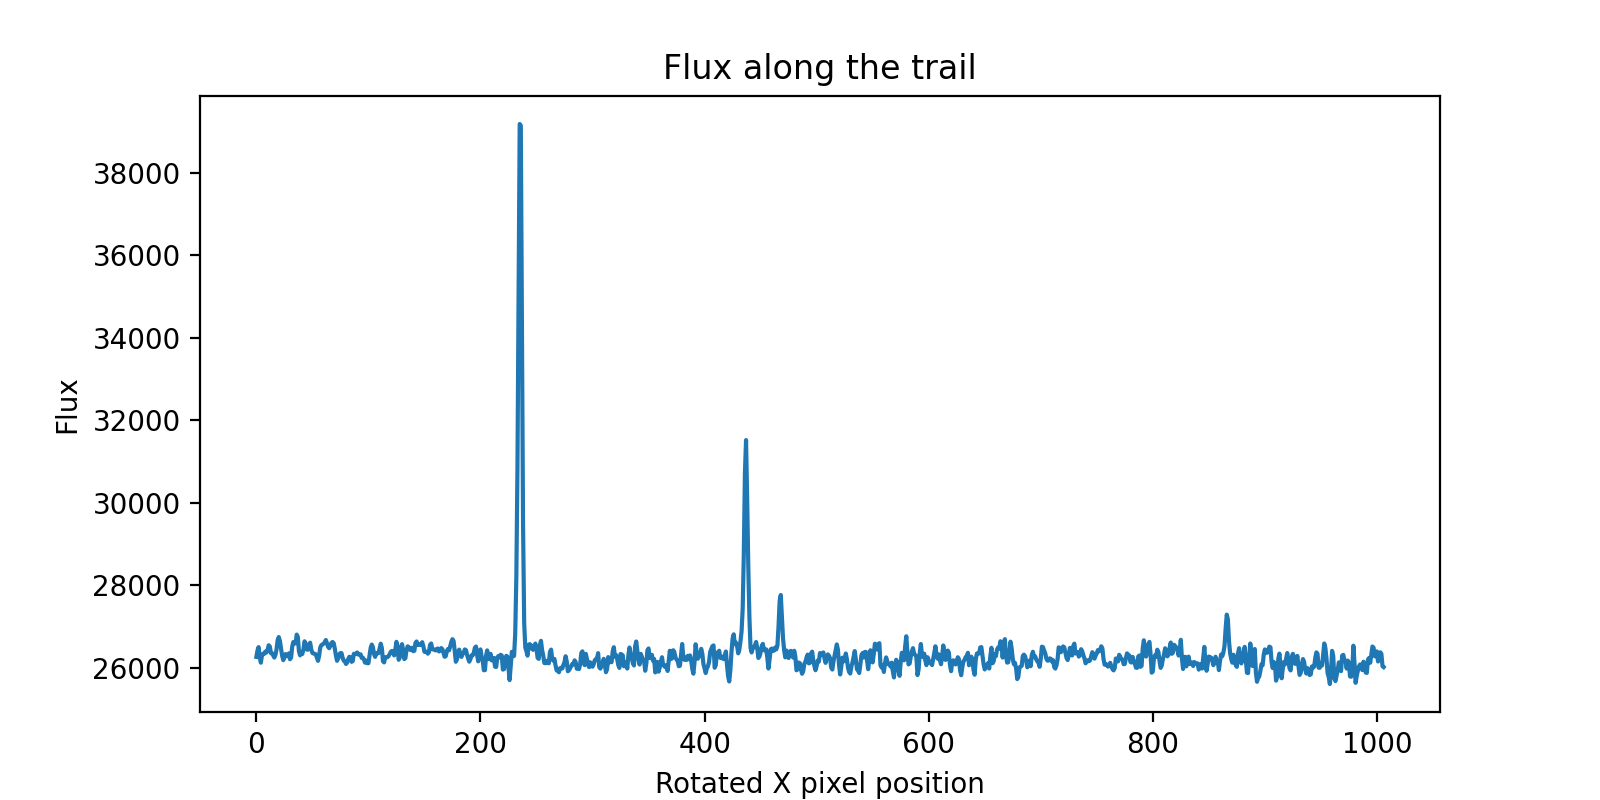

In [21]:
results1 = starlinkAnalyze(imageArray, header, 'dao', trailPoint1, trailPoint2,
                           nudge=2, trailWidth=12, doPlotProfiles=False)

In [22]:
frame = {'Starlink 2207': results1}
resultsDf = pd.DataFrame(frame)

In [23]:
resultsDf

,Starlink 2207
Airmass,1.16
Boresight Alt,59.67 deg
Boresight Az,92.56 deg
Corrected stationary mag,21.81
Corrected trail (mag),20.69 1 / arcsec2
Date and time (UTC),2021-07-28T04:54:08.000
Exposure time,10.0 s
Phase angle,118.72 deg
Raw trail (mag),23.19 1 / arcsec2
Raw trail flux,1930.81 nJy / arcsec2


### TODO: redo analysis with version of the FITS image that has pixel values in nJy
Until then, we cannot trust "Corrected stationary mag", "Raw trail (mag)", "Raw trail flux", "Stationary magnitude", or "Summed trail flux" (any fluxes or magnitude results).